# Ford GoBike System Data Usage Patterns
## by Darren Seet

## Preliminary Wrangling

> This data set contains anonymized trip data from the Bay Wheels bicycle sharing service operated by Bay Area Motivate, LLC ("Motivate"). Motivate is an organization that is committed to supporting bicycling as an alternative transportation option. The organization operates multiple bicycle sharing service progams. This dataset contains the data from the Ford GoBike program which is the second largest bike share program in the US with 7,000 bikes, serving San Francisco, San Jose and the East Bay. The dataset contains data for the full year of 2018, 2019 and partial data in 2017, 2020. This project will only look into the data for 2018 and 2019.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import requests
import os
from zipfile import ZipFile

## Configuration

In [2]:
%matplotlib inline
pandas_version = pd.__version__.split(".")
pd.set_eng_float_format(accuracy=6, use_eng_prefix=True)
plot_color = sb.color_palette()[0]


### Common Useful functions

In [3]:
def convert_to_ordered_category(series, categories):
    """Function to convert a series to an ordered category series

    Arguments:
    series --  Series to be converted
    categories -- Categories to be ordered
    """    
    if (int(pandas_version[0]) > 0) or (int(pandas_version[1]) >= 21): # v0.21 or later
        categories_ordered = pd.api.types.CategoricalDtype(ordered = True, categories = categories)
        return series.astype(categories_ordered)
    else: # compatibility for v.20
        return series.astype(
            'category', ordered = True,
             categories = categories
        )
    
def set_heatmap(ax, data, title, xlabel, ylabel):
    """Function to create a heatmap

    Arguments:
    ax -- Axes to plot
    data -- data source to be plotted
    title -- title of the plot
    xlabel -- label for x axis of plot
    ylabel -- label for y axis of plot
    """
    sb.heatmap(data, cmap='Blues', ax=ax);
    ax.set_title(title, loc='right', fontsize = 16);
    ax.set_xlabel(xlabel, fontsize = 14);
    ax.set_ylabel(ylabel, fontsize = 14);
    
def get_day_of_week_hour_count_for_dataframe(df_target):
    """Function to create a dataset for analysing the count by day of week and hour

    Arguments:
    df_target -- data source to be used for creating dataset
    """
    df_count = df_target.groupby(['day_of_week', 'hour']).size()
    df_count = df_count.reset_index(name='count')
    df_count = df_count.pivot(index='day_of_week', columns='hour', values='count')
    return df_count

def get_file_names(year):
    # Files after 2019-04 appear to be named as yyyyMM-baywheels-tripdata.csv
    return [
        f"{year}{month:02d}-fordgobike-tripdata.csv.zip" if (year != 2019 or month < 5) else f"{year}{month:02d}-baywheels-tripdata.csv.zip" for month in range(1, 13) 
    ]

def download_data_files(year):
    path = "data"
    if not os.path.exists(path):
        os.makedirs(path)
    
    for file_name in get_file_names(year):
        try:
            with open(f"{path}/{file_name}", 'wb') as file:
                file_request = requests.get(f"https://s3.amazonaws.com/baywheels-data/{file_name}")
                file.write(file_request.content)
                print(f"Downloaded {path}/{file_name}")
        except Exception as e:
            print(f"failed to get {file_name}: {e}")        
        
def extract_data_files(year):
    for file_name in get_file_names(year):
        try:
            with ZipFile(f"data/{file_name}") as zf:
                csv_file = file_name.replace(".zip", "")
                zf.extract(csv_file, path="data", pwd=None)
                print(f"Extracted data/{csv_file}")    
        except Exception as e:
            print(f"failed to get {file_name}: {e}")          

### Gather

#### Download Files

In [4]:
download_data_files(2018)
download_data_files(2019)

Downloaded data/201801-fordgobike-tripdata.csv.zip
Downloaded data/201802-fordgobike-tripdata.csv.zip
Downloaded data/201803-fordgobike-tripdata.csv.zip
Downloaded data/201804-fordgobike-tripdata.csv.zip
Downloaded data/201805-fordgobike-tripdata.csv.zip
Downloaded data/201806-fordgobike-tripdata.csv.zip
Downloaded data/201807-fordgobike-tripdata.csv.zip
Downloaded data/201808-fordgobike-tripdata.csv.zip
Downloaded data/201809-fordgobike-tripdata.csv.zip
Downloaded data/201810-fordgobike-tripdata.csv.zip
Downloaded data/201811-fordgobike-tripdata.csv.zip
Downloaded data/201812-fordgobike-tripdata.csv.zip
Downloaded data/201901-fordgobike-tripdata.csv.zip
Downloaded data/201902-fordgobike-tripdata.csv.zip
Downloaded data/201903-fordgobike-tripdata.csv.zip
Downloaded data/201904-fordgobike-tripdata.csv.zip
Downloaded data/201905-baywheels-tripdata.csv.zip
Downloaded data/201906-baywheels-tripdata.csv.zip
Downloaded data/201907-baywheels-tripdata.csv.zip
Downloaded data/201908-baywheels-t

#### Extract Csv

Original zip files contains MacOS related hidden files when ran on MacOS which causes the Pandas `read_csv` operation to fail to process the zip files. This step extracts the plain `.csv`. files for processing.

In [5]:
extract_data_files(2018)
extract_data_files(2019)

Extracted data/201801-fordgobike-tripdata.csv
Extracted data/201802-fordgobike-tripdata.csv
Extracted data/201803-fordgobike-tripdata.csv
Extracted data/201804-fordgobike-tripdata.csv
Extracted data/201805-fordgobike-tripdata.csv
Extracted data/201806-fordgobike-tripdata.csv
Extracted data/201807-fordgobike-tripdata.csv
Extracted data/201808-fordgobike-tripdata.csv
Extracted data/201809-fordgobike-tripdata.csv
Extracted data/201810-fordgobike-tripdata.csv
Extracted data/201811-fordgobike-tripdata.csv
Extracted data/201812-fordgobike-tripdata.csv
Extracted data/201901-fordgobike-tripdata.csv
Extracted data/201902-fordgobike-tripdata.csv
Extracted data/201903-fordgobike-tripdata.csv
Extracted data/201904-fordgobike-tripdata.csv
Extracted data/201905-baywheels-tripdata.csv
Extracted data/201906-baywheels-tripdata.csv
Extracted data/201907-baywheels-tripdata.csv
Extracted data/201908-baywheels-tripdata.csv
Extracted data/201909-baywheels-tripdata.csv
Extracted data/201910-baywheels-tripdat

#### Load Data

In [6]:
df_original = pd.concat([ pd.read_csv(file, low_memory=False) for file in glob.glob("data/*.csv") ])
df = df_original.copy()
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,598,2018-02-28 23:59:47.0970,2018-03-01 00:09:45.1870,284.000000,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114.000000,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,No,NaN
1,943,2018-02-28 23:21:16.4950,2018-02-28 23:36:59.9740,6.000000,The Embarcadero at Sansome St,37.804770,-122.403234,324.000000,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,No,NaN
2,18587,2018-02-28 18:20:55.1900,2018-02-28 23:30:42.9250,93.000000,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.000000,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,No,NaN
3,18558,2018-02-28 18:20:53.6210,2018-02-28 23:30:12.4500,93.000000,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.000000,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,No,NaN
4,885,2018-02-28 23:15:12.8580,2018-02-28 23:29:58.6080,308.000000,San Pedro Square,37.336802,-121.894090,297.000000,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,Yes,NaN


### Null Checking

This section runs a check through the data population for null values in all the columns. 

In [7]:
print(f"Total population count: {df.shape[0]}")
display(df.isnull().sum())

Total population count: 4370704


duration_sec                     0
start_time                       0
end_time                         0
start_station_id             92505
start_station_name           91904
start_station_latitude           0
start_station_longitude          0
end_station_id               94673
end_station_name             94121
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     243259
rental_access_method       4249866
dtype: int64

#### Null Handling

Null values are found in the columns
1. `start_station_id`
2. `start_station_name`
3. `end_station_id`
4. `end_station_name`
5. `rental_access_method`
6. `bike_share_for_all_trip`

For the project columns `rental_access_method` and `bike_share_for_all_trip` will be dropped since they are not among the features chosen for analysis.

After dropping the columns, we will then drop the records with null values in the `start_station_xx` and `end_station_xx` columns. This action will remove 100,000 records out of the total population of 4,370,704 observations between 2018 and 2019.

This project will the column `rental_access_method` and `bike_share_for_all_trip` which is unused. It will also  remove about 100,000 records out of 4,370,704 that contains null values for the period between 2018 and 2019

In [8]:
df.drop(["bike_share_for_all_trip", "rental_access_method"], axis=1, inplace=True)  
df.dropna(inplace=True)
print(f"Non Null Total population count: {df.shape[0]}")
display(df.isnull().sum())

Non Null Total population count: 4259209


duration_sec               0
start_time                 0
end_time                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
dtype: int64

### Augument Data

In this section, fields are added or modified to make the analysis process and easier. 

The fields that are added are:
1. year - year from start_time 
2. month - month from start_time
3. day of week - day of week from start_time  
4. hour - hour from start_time
5. duration - duration_sec convert to minutes
6. duration_group - duration convert to ordered category

The fields that are modified are:
1. user_type - converted to an ordered category
2. start_station_id - Type conversion to int
3. end_station_id - Type conversion to int
4. start_time - Type conversion to datetime
5. end_time - Type conversion to datetime

#### `start_station_id` and `end_station_id`

`start_station_id` and `end_station_id` appear to be of the wrong type `float64` for id values.  This is most likely due to NaN values causing Pandas to treat them as floats.  As part of the cleaning the columns will be converted to int64 with the null values as 0.

In [9]:
df.info()
df["start_station_id"] = df.start_station_id.astype("int64")
df["end_station_id"] = df.end_station_id.astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4259209 entries, 0 to 183411
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
dtypes: float64(6), int64(2), object(5)
memory usage: 454.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4259209 entries, 0 to 183411
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time             

#### `start_time` and `end_time`

`start_time` and `end_time` appear to be of the wrong type `object` (string). The project converts them to datetime for meaninful analysis.

In [10]:
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

#### `user_type`

`user_type` is converted into an ordered category series. This allows the more important users `Subscribers to be displyed first in a plot`.

In [11]:
df["user_type"] = convert_to_ordered_category(df["user_type"], ["Subscriber", "Customer"])

#### Year columns

Creating `year` columns for analysis by year

In [12]:
df["year"] = df.start_time.dt.year
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,year
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,2018
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,2018
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,2018
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,2018
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,2018


#### Month columns

Creating `month` for analysis by month

In [13]:
df["month"] = df.start_time.dt.month
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,year,month
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,2018,2
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,2018,2
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,2018,2
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,2018,2
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,2018,2


#### Day of week columns

`dayofweek` returns a numeric value from 0-6 where 0 represents Monday and 6 represents Sunday. This section creates the `day_of_week` column with values of Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday in a sorted order. This will allow analysis by day of week.

In [14]:
day_of_week = [
    "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
]

def day_of_week_category(row, date_column):
    return day_of_week[row[date_column].dayofweek]

df["day_of_week"] = df.apply(lambda row: day_of_week_category(row, "start_time"), axis = 1)
df["day_of_week"] = convert_to_ordered_category(df["day_of_week"], day_of_week)
    
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,year,month,day_of_week
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,2018,2,Wednesday
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,2018,2,Wednesday
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,2018,2,Wednesday
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,2018,2,Wednesday
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,2018,2,Wednesday


#### Hour columns

Creating `hour` columns for analysis by hour of day

In [15]:
df["hour"] = df.start_time.dt.hour
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,year,month,day_of_week,hour
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,2018,2,Wednesday,23
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,2018,2,Wednesday,23
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,2018,2,Wednesday,18
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,2018,2,Wednesday,18
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,2018,2,Wednesday,23


#### Duration column

Creating `duration` columns for analysis of duration by minutes

In [16]:
df["duration"] = df.duration_sec / 60
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,year,month,day_of_week,hour,duration
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,2018,2,Wednesday,23,9.966667
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,2018,2,Wednesday,23,15.716667
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,2018,2,Wednesday,18,309.783333
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,2018,2,Wednesday,18,309.300000
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,2018,2,Wednesday,23,14.750000


#### Duration Category

Creating duration group to analysis the duration group that is most used by the users

In [17]:
duration_category_groups = [
    ">= 5", "< 5 and >= 10", "< 10 and <= 20", 
    "< 20 and <= 30", "< 30 and <= 40", "< 40 and <= 50",
    "< 50 and <= 60", "> 60"
]

def duration_category(row, duration_column):
    if row[duration_column] <= 5:
        return duration_category_groups[0] 
    elif row[duration_column] <= 10:
        return duration_category_groups[1] 
    elif row[duration_column] <= 20:
        return duration_category_groups[2]     
    elif row[duration_column] <= 30:
        return duration_category_groups[3]  
    elif row[duration_column] <= 40:
        return duration_category_groups[4] 
    elif row[duration_column] <= 50:
        return duration_category_groups[5]
    elif row[duration_column] <= 60:
        return duration_category_groups[6] 
    return duration_category_groups[7]

df["duration_group"] = df.apply(lambda row: duration_category(row, "duration"), axis = 1)
df["duration_group"] = convert_to_ordered_category(df["duration_group"], duration_category_groups)

### Final Schema

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4259209 entries, 0 to 183411
Data columns (total 19 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         int64         
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           int64         
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  int64         
 12  user_type                category      
 13  year                     int64         
 14  month                    int64         
 15  day_of_week              category      
 16  hour                     int64         
 17  duration                 flo

### Categorical Data Exploration

#### start_station_xx fields

It appears that a single `start_station_id` can have multiple `start_station_name`, `start_station_latitude` and `start_station_longitude`. This indicates that a station id can have multiple spots in the vicinity

In [19]:
df_start_stations = df.groupby(
    ["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]
).size().reset_index().rename({0: "count"}, axis=1)

display(df_start_stations[df_start_stations.duplicated("start_station_id")].sort_values(["start_station_id"]).head(10))
df_start_stations.query("start_station_id == 101")

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,count
23,25,Howard St at 2nd St,37.787522,-122.397405,13286
35,37,2nd St at Folsom St,37.785377,-122.396906,4815
36,37,Folsom St at 2nd St,37.785377,-122.396906,4388
77,80,Townsend St at 5th St,37.775306,-122.397380,9075
96,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,2537
97,101,San Bruno Ave at 16th St,37.766008,-122.405677,2445
123,130,22nd St Caltrain Station,37.757369,-122.392057,5810
124,130,22nd St Caltrain Station,37.757704,-122.391885,7198
125,130,22nd St Caltrain Station,37.757718,-122.391813,3009
165,173,Shattuck Ave at 55th St,37.840364,-122.264488,3655


,start_station_id,start_station_name,start_station_latitude,start_station_longitude,count
95,101,15th St at Potrero Ave,37.767079,-122.407359,8236
96,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,2537
97,101,San Bruno Ave at 16th St,37.766008,-122.405677,2445


#### end_station_xx fields

It appears that a single `end_station_id` can have multiple `end_station_name`, `end_station_latitude` and `end_station_longitude`. This indicates that a station id can have multiple spots in the vicinity

In [20]:
df_end_stations = df.groupby(
    ["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]
).size().reset_index().rename({0: "count"}, axis=1)

display(df_end_stations[df_end_stations.duplicated("end_station_id")].sort_values(["end_station_id"]).head(10))
df_end_stations.query("end_station_id == 130")

,end_station_id,end_station_name,end_station_latitude,end_station_longitude,count
23,25,Howard St at 2nd St,37.787522,-122.397405,12886
35,37,2nd St at Folsom St,37.785377,-122.396906,4274
36,37,Folsom St at 2nd St,37.785377,-122.396906,3558
77,80,Townsend St at 5th St,37.775306,-122.397380,7702
96,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,2597
97,101,San Bruno Ave at 16th St,37.766008,-122.405677,2433
123,130,22nd St Caltrain Station,37.757369,-122.392057,5797
124,130,22nd St Caltrain Station,37.757704,-122.391885,6401
125,130,22nd St Caltrain Station,37.757718,-122.391813,2977
165,173,Shattuck Ave at 55th St,37.840364,-122.264488,3514


,end_station_id,end_station_name,end_station_latitude,end_station_longitude,count
122,130,22nd St Caltrain Station,37.757288,-122.392051,4386
123,130,22nd St Caltrain Station,37.757369,-122.392057,5797
124,130,22nd St Caltrain Station,37.757704,-122.391885,6401
125,130,22nd St Caltrain Station,37.757718,-122.391813,2977


#### User Type

The dataset identifies the users as Customer and Subscriber which differentiates between regular users and on-off users.

In [21]:
df_user_type = df.groupby(
    ["user_type"]
).size().reset_index().rename({0: "count"}, axis=1)

df_user_type

,user_type,count
0,Subscriber,3510033
1,Customer,749176


### What is the structure of your dataset?

> The data set contains the following features in the data categories
> - Quantitative
>   1. Trip Duration (seconds)
>   2. Trip Duration (minutes)  
>   3. Start Time and Date
>   4. End Time and Date
> - Qualitative
>   1. Start Station ID
>   2. Start Station Name
>   3. End Station ID
>   4. End Station Name
>   5. Bike ID
>   6. User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
>   7. Year             
>   8. Month               
>   9. Day of Week            
>   10. Hour     
>   11. Duration Group
### What is/are the main feature(s) of interest in your dataset?

> The dataset contains the features that will enable us to study usage of the bikes in the following ares:
> 1. Bike sharing usage duration by year
> 2. Bike sharing usage duration by month
> 3. Bike sharing usage duration by day of week
> 4. Bike sharing usage duration by hour
> 5. Bike sharing usage duration by user type

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Year, Month, Day of Week and Hour are generated columns that will allow different views into the period of usage
> Duration provides a view into the length of usage
> User type provides a view into how many are regular users
> Start Station ID, Start Station Name, End Station ID and End Station Name provides a view into the geographic usage patterns

## Univariate Exploration

### Duration

This distribution of usage in minutes `duration` appears to be concentrated in the range below 1 hours (60 minutes). The data also shows a long tail to the right of the histogram.

interquartile range (IQL): Q3 - Q1 = 878 - 355 = 523

Duration min: 1.0, max 1439.4333333333334
Percentage duration within 1 hour: 98.59802606540322


count    4.259209M
mean     13.762788
std      35.133553
min       1.000000
25%       5.916667
50%       9.383333
75%      14.633333
max      1.439433k
Name: duration, dtype: float64

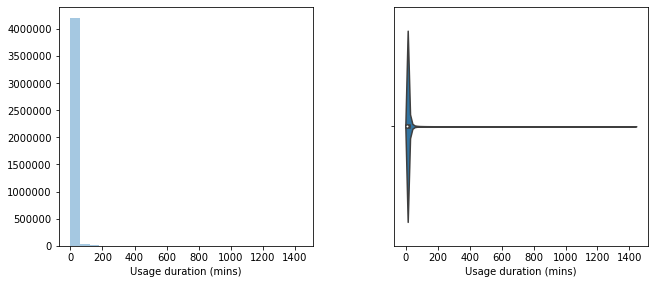

In [22]:
total_count = df.shape[0]
print(f"Duration min: {df.duration.min()}, max {df.duration.max()}")
print(
    f"Percentage duration within 1 hour: {df.query('duration <= 60').shape[0] / total_count * 100}"
)
display(df.duration.describe())
fig, (ax1, ax2)  = plt.subplots(
    1, 2, figsize=(10, 5)
)
fig.tight_layout(pad=5)
sb.distplot(
    df["duration"], bins=np.arange(0,df.duration.max() + 60, 60), ax=ax1, kde=False
);
ax1.set_xlabel("Usage duration (mins)");
sb.violinplot(data = df, x = 'duration', ax=ax2);
ax2.set_xlabel("Usage duration (mins)");

#### Scaling Duration

Performing a log scale operation on `duration_sec` produces a distribution that is closer to a normal distribution. But the long tail on the right still exists and it contains about 0.56% of the usage population.

Percentage duration more 2 hour: 0.5642831802806577


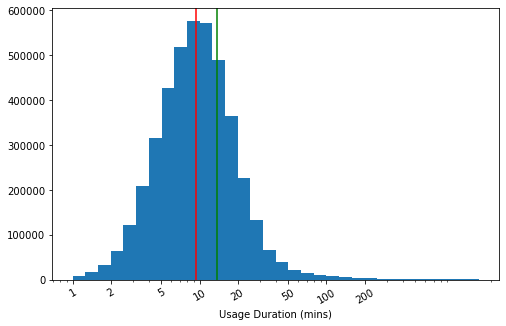

In [23]:
print(
    f"Percentage duration more 2 hour: {df.query('duration > 120').shape[0] / total_count * 100}"
)

scaled_duration = {
    "bins": 10 ** np.arange(
        0, np.log10(df["duration"].max()) + 0.1, 0.1
    ),
    "bin_ticks": [1, 2, 5, 10, 20, 50, 100, 200], 
    "bin_labels": [1, 2, 5, 10, 20, 50, 100, 200],
    "scale": "log"
}

plt.figure(figsize=[8, 5]);
plt.hist(data = df, x = "duration", bins = scaled_duration["bins"]);
plt.xscale(scaled_duration["scale"]);
plt.xticks(scaled_duration["bin_ticks"], scaled_duration["bin_labels"], rotation=30);
plt.xlabel('Usage Duration (mins)');
plt.axvline(df.duration.median(), color='r', label='Median');
plt.axvline(df.duration.mean(), color='g', label='Mean');

#### Remove Duration Outliers

In this study we will remove the outliers

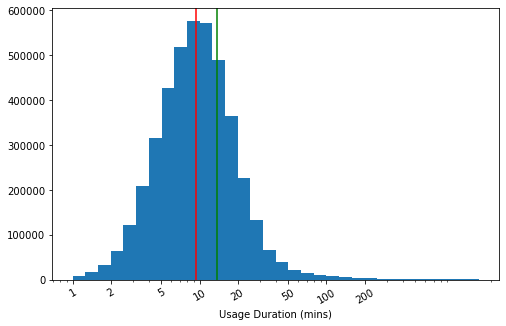

In [24]:
df = df.query('duration <= 7200')

scaled_duration = {
    "bins": 10 ** np.arange(
        0, np.log10(df["duration"].max()) + 0.1, 0.1
    ),
    "bin_ticks": [1, 2, 5, 10, 20, 50, 100, 200], 
    "bin_labels": [1, 2, 5, 10, 20, 50, 100, 200],
    "scale": "log"
}

plt.figure(figsize=[8, 5]);
plt.hist(data = df, x = "duration", bins = scaled_duration["bins"]);
plt.xscale(scaled_duration["scale"]);
plt.xticks(scaled_duration["bin_ticks"], scaled_duration["bin_labels"], rotation=30);
plt.xlabel('Usage Duration (mins)');
plt.axvline(df.duration.median(), color='r', label='Median');
plt.axvline(df.duration.mean(), color='g', label='Mean');

### Hour

An analysis of the usage by the hour shows the usage to be bimodal with the majority of the usage occurring in the time from 6:00 to 23:00. The usage has 2 peaks during 7:00 - 9:00 and 16:00 - 19:00 which is pretty close to the peak hours listed on the [City and County of San Francisco site](https://sfgov.org/scorecards/transportation/congestion) as AM peak 7:00 a.m. - 9:00 a.m., and PM peak as 4:30 p.m. - 6:30 p.m.

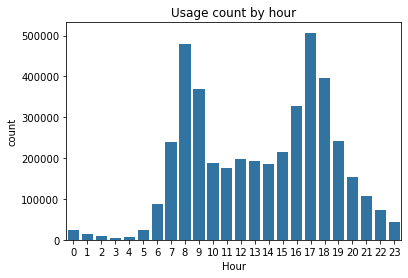

In [25]:
ax = sb.countplot(data= df, x="hour", color=plot_color);
ax.set_xlabel("Hour");
ax.set_title("Usage count by hour");

### Start Day Of Week

An analysis of the usage by day of week of shows the usage to be higher on the weekdays from Monday to Friday.

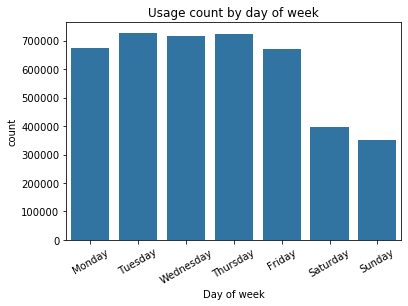

In [26]:
ax = sb.countplot(data= df, x="day_of_week", color=plot_color);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set_xlabel("Day of week");
ax.set_title("Usage count by day of week");

### Month

An analysis of the usage by month of shows the usage to be consistent throughout the months with the start of the year Jan - Feb and end of year Nov - Dec having lower usage.

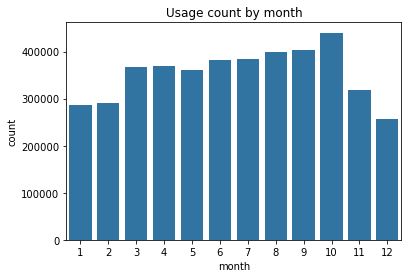

In [27]:
ax = sb.countplot(data= df, x="month", color=plot_color);
ax.set_xlabel("month");
ax.set_title("Usage count by month");

### Year

An analysis of the usage by year of shows an increas in usage in 2019 compared to 2018.

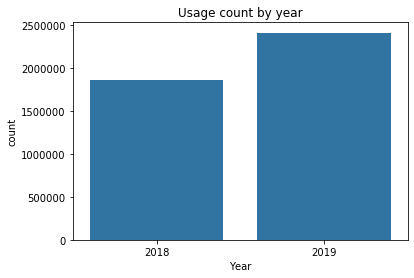

In [28]:
ax = sb.countplot(data= df, x="year", color=plot_color);
ax.set_xlabel("Year");
ax.set_title("Usage count by year");

### User Type

An analysis of the user type shows a high bias to Subscribers compared to Customers

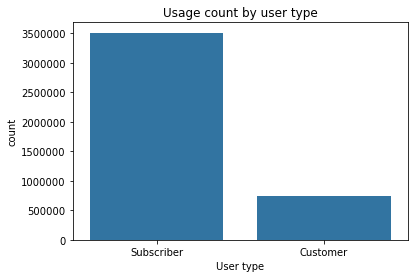

In [29]:
ax = sb.countplot(data= df, x="user_type", color=plot_color);
ax.set_xlabel("User type");
ax.set_title("Usage count by user type");

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data.

### Year by user type

The usage of the rider sharing service shows increases for both the Subscriber and Customer Types.

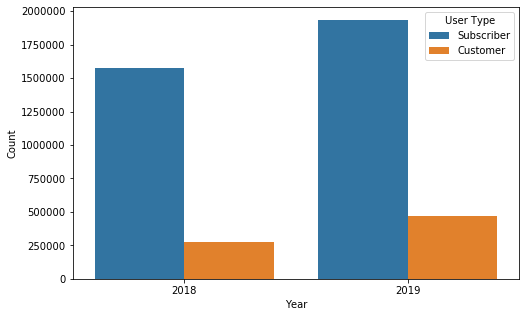

In [30]:
plt.figure(figsize=(8,5))
sb.countplot(data=df, x="year", hue="user_type");
plt.xlabel("Year");
plt.ylabel("Count");
plt.legend(title="User Type");

### Ride Duration by hour

Looking into the average ride duration on the hour, there is an interesting observation that the duration increases during the midnight 0:00 - 4:00 in the early morning. 

(0, 40)

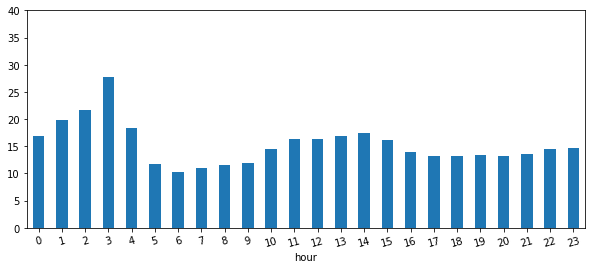

In [31]:
df.groupby('hour').duration.mean().reset_index().plot(
    x='hour', y='duration', kind='bar', color=plot_color, legend=False, figsize=(10,4)
)
plt.xticks(rotation = 15);
plt.ylim(0,40)

### Ride Duration by day of week

Looking into the average ride duration by the day of the week, there is an interesting observation that the duration increases during the weekends compared to the weekdays. 

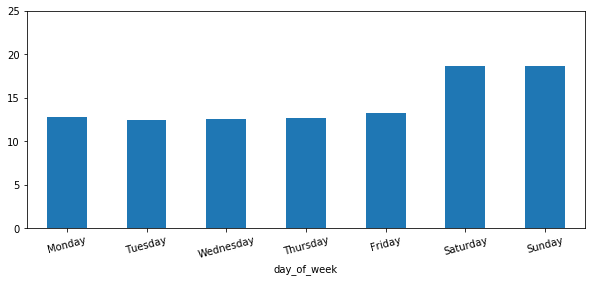

In [32]:
df.groupby('day_of_week').duration.mean().reset_index().plot(
    x='day_of_week', y='duration', kind='bar', color=plot_color, legend=False, figsize=(10,4)
)
plt.xticks(rotation = 15);
plt.ylim(0,25);

### Ride Duration by month

The ride duration does not appear to differ by the month

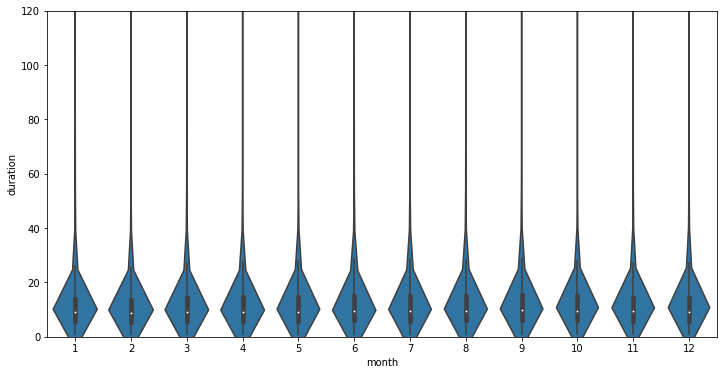

In [33]:
plt.figure(figsize = (12,6))
sb.violinplot(data = df, x = 'month', y = 'duration', color = plot_color)
plt.ylim(0,120);

### Ride Duration by year

The ride duration does not appear to differ by the year

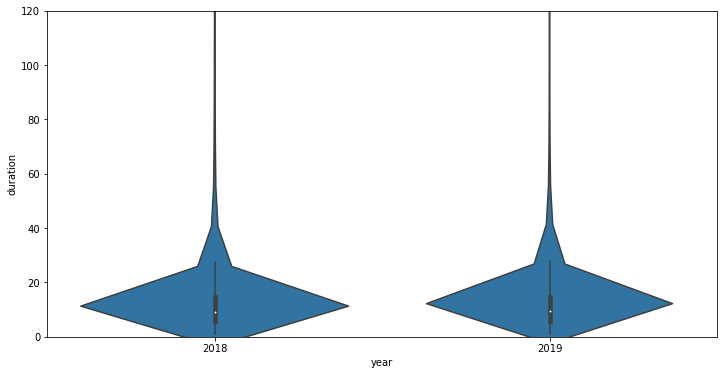

In [34]:
plt.figure(figsize = (12,6))
sb.violinplot(data = df, x = 'year', y = 'duration', color = plot_color)
plt.ylim(0,120);

### Ride Duration by User Type

Looking into the average ride duration on the hour, there is an interesting observation that the duration increases during the midnight 0:00 - 4:00 in the early morning. 

(0, 40)

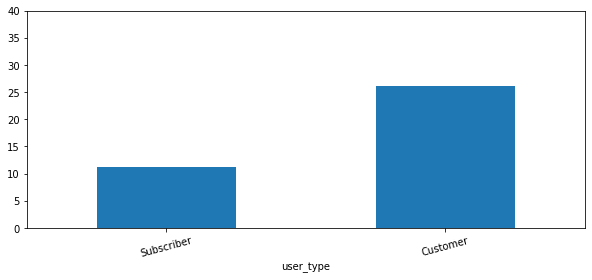

In [35]:
df.groupby('user_type').duration.mean().reset_index().plot(
    x='user_type', y='duration', kind='bar', color=plot_color, legend=False, figsize=(10,4)
)
plt.xticks(rotation = 15);
plt.ylim(0,40)

### Ride Duration Groups By Day of Week

It appears that the majority of the usage is centered around 5 to 20 minutes, this shows that the majority of the bike trips tend to be short ones.

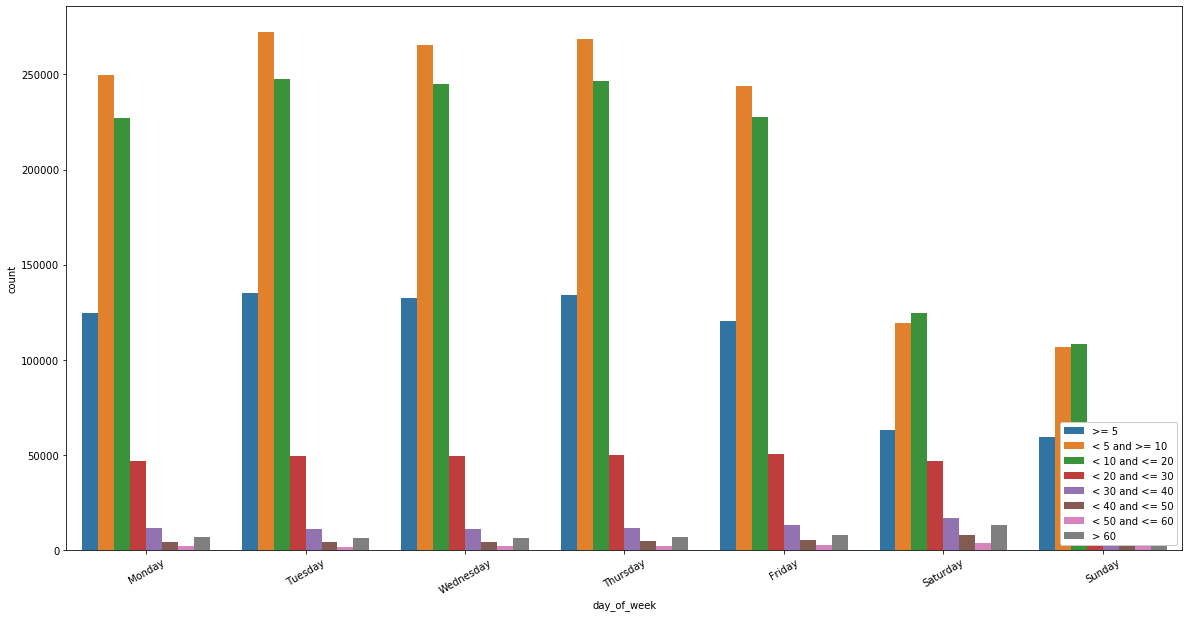

In [36]:
plt.figure(figsize=(20, 10))
ax = sb.countplot(data = df, x = 'day_of_week', hue = 'duration_group')
ax.legend(loc = 4, framealpha = 1) # lower right, no transparency
plt.xticks(rotation = 30);

## Multivariate Exploration

> Plotting of three or more variables to investigate your data following previous observations

### Hourly Usage By Day of Week By Year

In the previous observations usage was observed to be bias towards the peak hours during the weekdays. A futher analysis was carried out and adding in different features like the year shows the same reason. This provides strong evidences that the use of ride sharing services might be used for commuting to work.

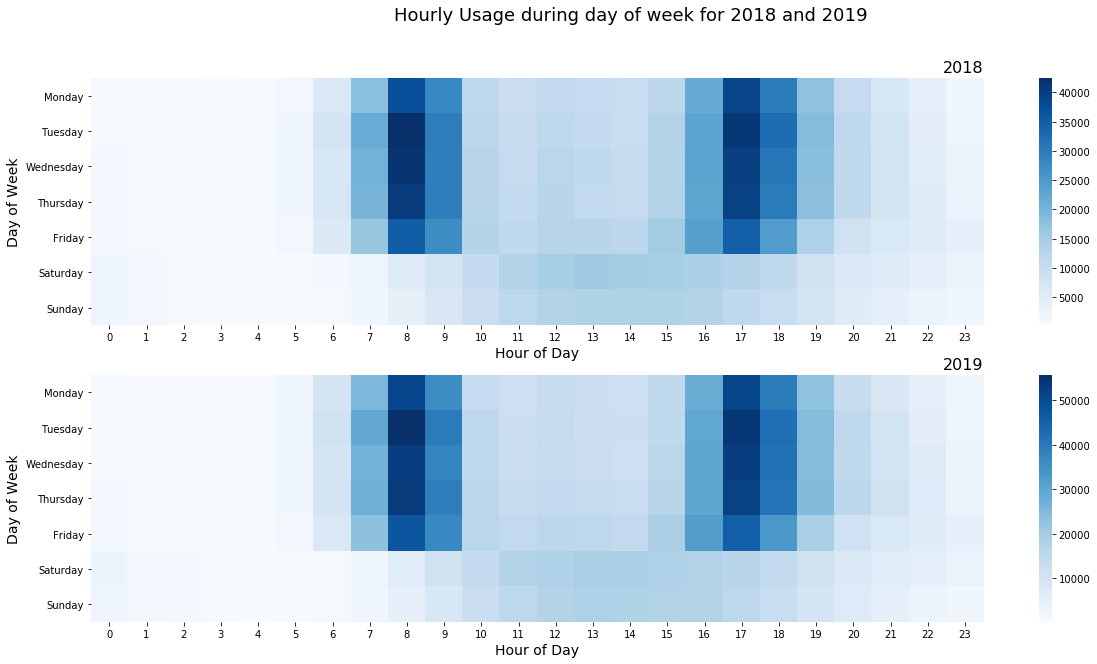

In [37]:
df_2018 = get_day_of_week_hour_count_for_dataframe(df.query("year == 2018"))
df_2019 = get_day_of_week_hour_count_for_dataframe(df.query("year == 2019"))
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(20, 10)
)
plt.suptitle("Hourly Usage during day of week for 2018 and 2019", fontsize = 18)
set_heatmap(ax1, df_2018, "2018", "Hour of Day", "Day of Week")
set_heatmap(ax2, df_2019, "2019", "Hour of Day", "Day of Week")

### Mean Duration By Hour and Year and Usage Count By Hour and Year

It appears that mean duration by hour is reduced comparing 2018 to 2019 although usage count has actually increased in using the same features. Another intersting fact is although the average duration is a lot higher during the non commuting hours from 0:00 - 4:00, the average duration comes from low usage counts in the same hours. While the average duration is alot lower during the commuting hours the usage count is actually much higher.

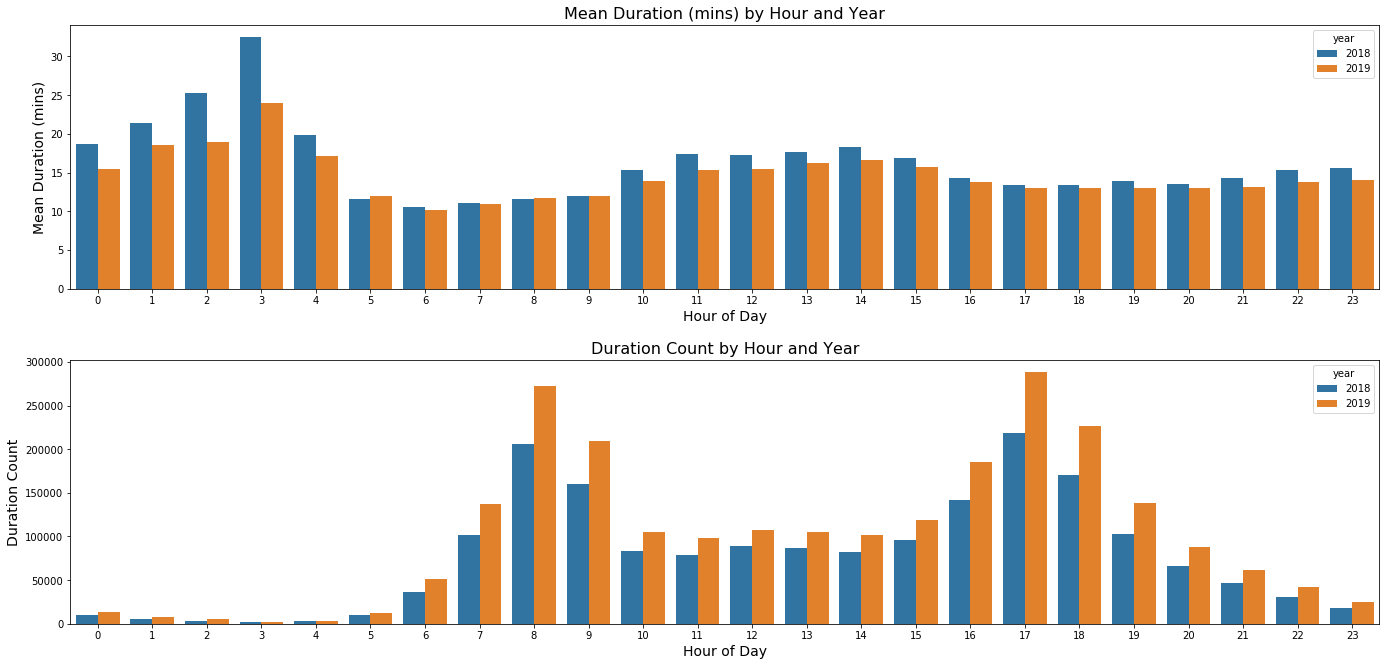

In [38]:
def set_barplot_by_hour_year(ax, data, title, xlabel, ylabel):
    """Function to create a barplot by hour year.

    Arguments:
    ax -- Axes to plot
    data -- data source to be plotted
    title -- title of the plot
    xlabel -- label for x axis of plot
    ylabel -- label for y axis of plot
    """
    sb.barplot( 
        data=df.groupby(['year', 'hour']).duration.mean().reset_index(), 
        x="hour", y="duration", hue="year", ax=ax
    )    
    ax.set_title(title, loc='right', fontsize = 16);
    ax.set_xlabel(xlabel, fontsize = 14);
    ax.set_ylabel(ylabel, fontsize = 14);

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(20, 10)
)
fig.tight_layout(pad=5)

sb.barplot( 
    data=df.groupby(['year', 'hour']).duration.mean().reset_index(), 
    x="hour", y="duration", hue="year", ax=ax1
)
ax1.set_xlabel('Hour of Day', fontsize=14);
ax1.set_ylabel('Mean Duration (mins)', fontsize=14);
ax1.set_title('Mean Duration (mins) by Hour and Year', fontsize=16);

sb.countplot( 
    data=df, 
    x="hour", hue="year", ax=ax2
)
ax2.set_xlabel('Hour of Day', fontsize=14);
ax2.set_ylabel('Duration Count', fontsize=14);
ax2.set_title('Duration Count by Hour and Year', fontsize=16);

### Hourly Usage By Day of Week By User Type

Performing the Heatmap analysis of the hourly usage by day of week and user type shows similar heavy usage during the peak hours. It also displays another use by the Customer user types. Customer user types also shows heavy usage during the weekends (Saturday and Sunday) from 9:00 to 18:00. This is on top of the heavy usage in the during the weekday peak hours. Although subscribers contain a higher percentage of the population data compared to the customers.

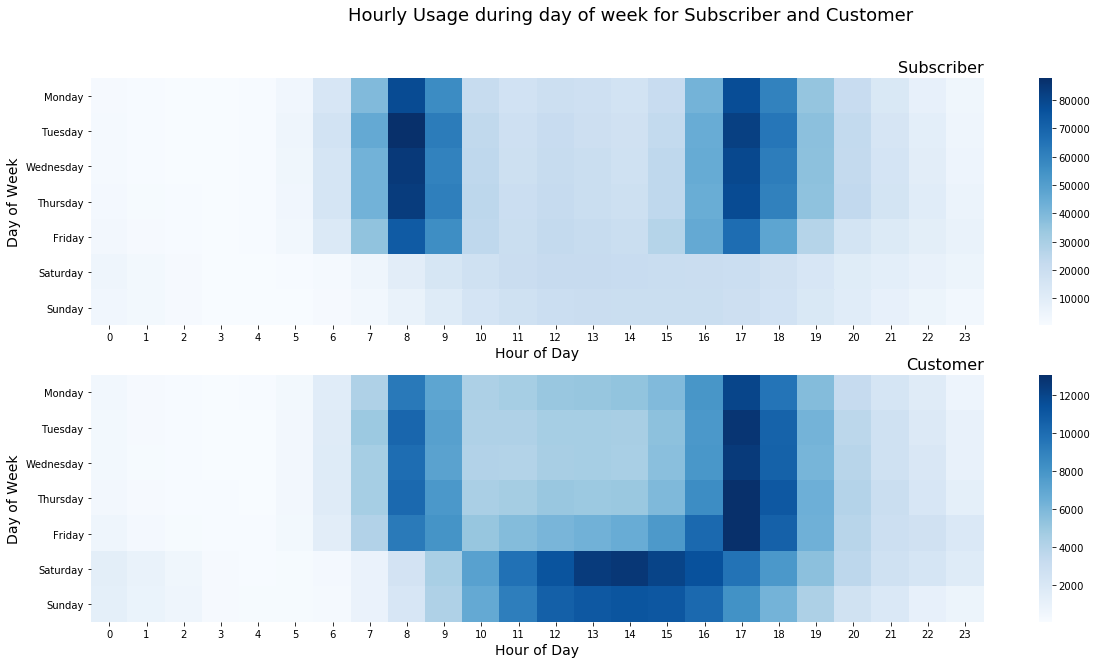

In [39]:
df_subscriber = get_day_of_week_hour_count_for_dataframe(df.query("user_type == 'Subscriber'"))
df_customer = get_day_of_week_hour_count_for_dataframe(df.query("user_type == 'Customer'"))
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(20, 10)
)
plt.suptitle("Hourly Usage during day of week for Subscriber and Customer", fontsize = 18)
set_heatmap(ax1, df_subscriber, "Subscriber", "Hour of Day", "Day of Week")
set_heatmap(ax2, df_customer, "Customer", "Hour of Day", "Day of Week")

### Mean Duration By Hour and User Type and Usage Count By Hour and Usage Type

Performing the Mean Duration and Usage Count analysis on the usage type presented an interesting view. As expected usage count is heavily tilted towards the subscribers. Although customers tend to make trips that have higher duration compared to the subscribers.

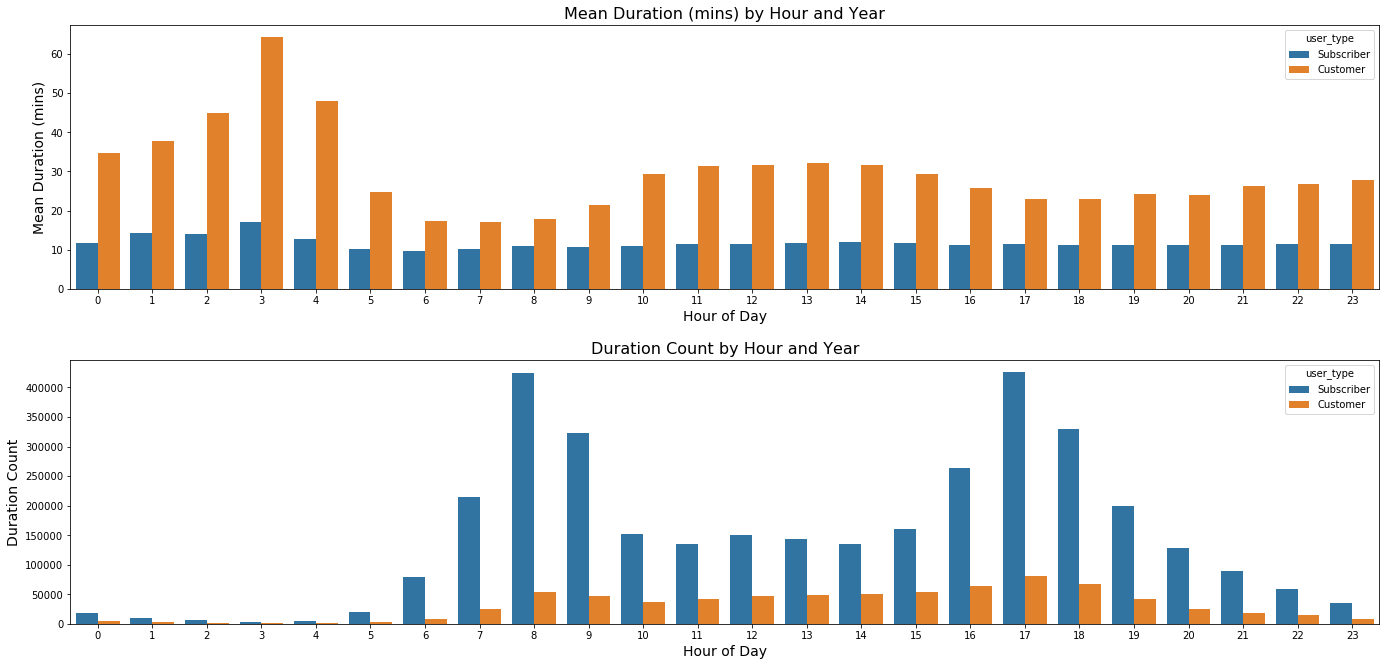

In [40]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(20, 10)
)
fig.tight_layout(pad=5)

sb.barplot( 
    data=df.groupby(['user_type', 'hour']).duration.mean().reset_index(), 
    x="hour", y="duration", hue="user_type", ax=ax1
)
ax1.set_xlabel('Hour of Day', fontsize=14);
ax1.set_ylabel('Mean Duration (mins)', fontsize=14);
ax1.set_title('Mean Duration (mins) by Hour and Year', fontsize=16);

sb.countplot( 
    data=df, 
    x="hour", hue="user_type", ax=ax2
)
ax2.set_xlabel('Hour of Day', fontsize=14);
ax2.set_ylabel('Duration Count', fontsize=14);
ax2.set_title('Duration Count by Hour and Year', fontsize=16);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> In this investigation we look into the Ford GoBike System that shows relationships between the usage behaviour in relation to the day of the week, time of the day and also the duration of usage. 

###  Interesting or surprising interactions between features?

> * Peak hours in Weekdays (7:00 - 9:00 and 16:00 - 19:00) display a high amount of usage 
> * Customer user types also uses the system during the day time on the Weekends.
> * Customer user types tend to make trips with longer durations.
> * Usage patterns appear to be very consistent across 2018 and 2019 except for durations
> * 2018 usage durations tend to be longer although 2019 has higher usage counts.

#### Persist datasource for easier use during reporting

In [41]:
df.to_csv("report_source.csv", index=False)